<a href="https://colab.research.google.com/github/ChinmayParanjape/Satellite-imagery-segmentation-using-U-NET/blob/main/SEGMENTATION_MODEL_AND%C2%A0_PREPROCESSING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2 #pip install opencv-python
import numpy as np

from matplotlib import pyplot as plt
! pip install patchify
from patchify import patchify #pip install patchify

from PIL import Image
!pip install -U segmentation-models
import segmentation_models as sm # !pip install -U segmentation-models
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
root_directory = '/content/drive/MyDrive/IMARTICUS/LAND/Tile 1'

patch_size = 256

In [ ]:
for path, subdirs, files in os.walk(root_directory):
    #print(path) 
    dirname = path.split(os.path.sep)[-1]
    #print(dirname)
    if dirname == 'masks':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".png"):
              print(image_name) 

image_part_004.png
image_part_009.png
image_part_007.png
image_part_008.png
image_part_005.png
image_part_006.png
image_part_002.png
image_part_003.png
image_part_001.png
image_part_0018.png
image_part_0017.png
image_part_0016.png
image_part_0015.png
image_part_0014.png
image_part_0013.png
image_part_0012.png
image_part_0011.png
image_part_0010.png


In [ ]:
image_dataset = []
for y in range(1,19):
  image = cv2.imread(f'/content/drive/MyDrive/IMARTICUS/LAND/Tile 1/images/image_part_00{y}.jpg',1) 
  SIZE_X = (image.shape[1]//patch_size)*patch_size 
  SIZE_Y = (image.shape[0]//patch_size)*patch_size 
  image = Image.fromarray(image)
  image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
  image = np.array(image) 
  patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i,j,:,:]
      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
      single_patch_img = single_patch_img[0] 
      image_dataset.append(single_patch_img) 

In [ ]:
#cv2.imread(f'/content/drive/MyDrive/IMARTICUS/LAND/Tile 1/masks/image_part_00{y}.png',1)

In [ ]:
mask_dataset = []
for y in range(1,19):
  mask = cv2.imread(f'/content/drive/MyDrive/IMARTICUS/LAND/Tile 1/masks/image_part_00{y}.png',1)
  mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
  SIZE_X = (mask.shape[1]//patch_size)*patch_size 
  SIZE_Y = (mask.shape[0]//patch_size)*patch_size 
  mask = Image.fromarray(mask)
  mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  

  mask = np.array(mask)             
        
  patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  
          
  for i in range(patches_mask.shape[0]):
    for j in range(patches_mask.shape[1]):
      single_patch_mask = patches_mask[i,j,:,:]
    
      single_patch_mask = single_patch_mask[0]                         
      mask_dataset.append(single_patch_mask) 

In [ ]:
len(mask_dataset)

414

In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [ ]:
print(len(mask_dataset),len(mask_dataset))

414 414


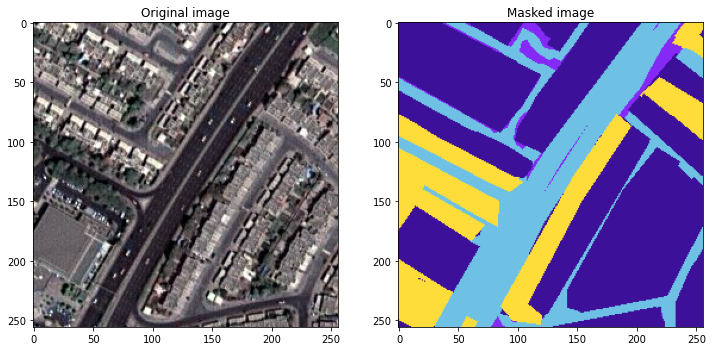

In [ ]:

import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.title('Original image')
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.title('Masked image')
plt.show()

In [ ]:

a=int('3C', 16)  
#print(a)

Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152 #blue

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246 #light blue with purpule shade

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228 # light blue

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58 # yellow

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41 # littile bit orange shade

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155 # light gray scaled

label = single_patch_mask

In [ ]:
def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    label_seg = label_seg[:,:,0]  
    return label_seg

In [ ]:
range(mask_dataset.shape[0])

range(0, 414)

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


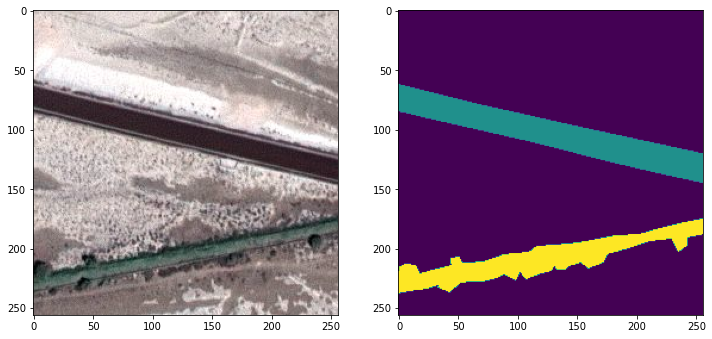

In [ ]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [ ]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
print('IMG_HEIGHT',IMG_HEIGHT)
print('IMG_WIDTH',IMG_WIDTH)
print('IMG_CHANNELS',IMG_CHANNELS)

IMG_HEIGHT 256
IMG_WIDTH 256
IMG_CHANNELS 3


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])    
    return model

In [ ]:
metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
import tensorflow as tf
tf.keras.backend.clear_session()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
21/21 [==============================] - 27s 341ms/step - loss: 1.0054 - accuracy: 0.4455 - jacard_coef: 0.2049 - val_loss: 0.9975 - val_accuracy: 0.5064 - val_jacard_coef: 0.2245
Epoch 2/100
21/21 [==============================] - 4s 178ms/step - loss: 0.9953 - accuracy: 0.4746 - jacard_coef: 0.2579 - val_loss: 0.9887 - val_accuracy: 0.5374 - val_jacard_coef: 0.3077
Epoch 3/100
21/21 [==============================] - 4s 176ms/step - loss: 0.9868 - accuracy: 0.5371 - jacard_coef: 0.3056 - val_loss: 0.9813 - val_accuracy: 0.6109 - val_jacard_coef: 0.2957
Epoch 4/100
21/21 [==============================] - 4s 176ms/step - loss: 0.9755 - accuracy: 0.6141 - jacard_coef: 0.3452 - val_loss: 0.9689 - val_accuracy: 0.6361 - val_jacard_coef: 0.3705
Epoch 5/100
21/21 [==============================] - 4s 178ms/step - loss: 0.9601 - accuracy: 0.6425 - jacard_coef: 0.3930 - val_loss: 0.9581 - val_accuracy: 0.6610 - val_jacard_coef: 0.3873
Epoch 6/100
21/21 [=========================

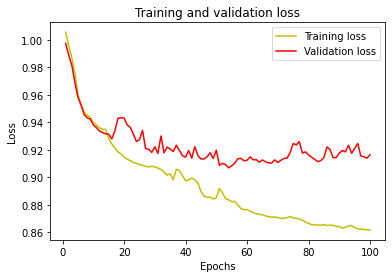

In [ ]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

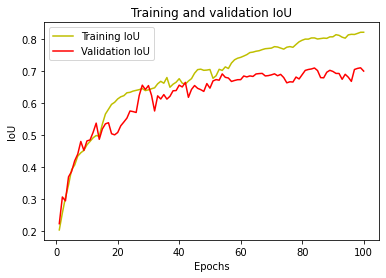

In [ ]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

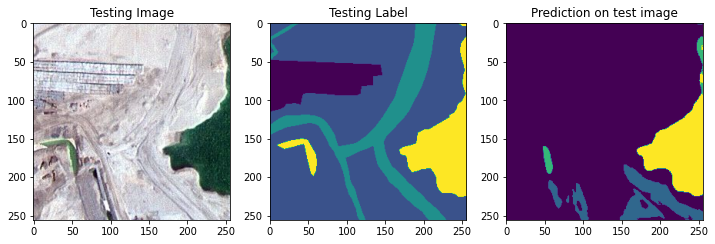

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()